# <font color='green'>**Hopfield Neural Network on Lab-Teacher Problem**</font>



---

by Chakrit, Pimpunyawat, Rapeepan

---
September 2024



---


---


The basic concept is the following


---


**Set up**

The states are labeled by $u_{\alpha jk}$ where $\alpha$ indicates the class $\alpha^{\rm th}$, $j$ indicates the teacher $j^{\rm th}$ and $k$ indicates the period $k^{\rm th}$

The activation function is discrete, i.e., $v_{\alpha jk} = g(u_{\alpha jk})$ where
$v_{\alpha jk} = 0$ when $u_{\alpha jk} \leq 0$ and $v_{\alpha jk} = 1$ when $u_{\alpha jk} > 0$

The energy function is written in terms of the activation output + external output with a weighted matrix as follow:

$E = -\frac{1}{2}\sum\limits_{\alpha,j,k,\alpha',j',k'} W_{\alpha'j'k'\alpha jk}v_{\alpha 'j'k'}v_{\alpha jk} - \sum\limits_{\alpha jk}I_{\alpha jk}v_{\alpha jk}$

---

**Constraints**

The constraints are the following:

$\sum\limits_{k=1}^{P} v_{\alpha jk} = L_{\alpha j}$: The requirement from school that for the j$^{\rm th}$ teacher should teach $L_{\alpha j}$ times for the $\alpha^{\rm th}$ lab.

$\sum\limits_{j=1}^{T} v_{\alpha jk} = n_{\alpha} M_{\alpha k}$: The requirement that $n_{\alpha}$ teachers teach the same lab at the same time, where $M_{\alpha k}$ is 1 for the period $k$ that the lab take place and 0 for the period with no lab.

$\sum\limits_{\alpha=1}^{L} v_{\alpha jk} \leq 1$: The requirement that no 2 labs were taught by the same teacher at the same time.

---
**Weight and Input**

From the energy term:

$E = \frac{A}{2}\sum\limits_{\alpha}^L \sum\limits_j^T \left(\sum\limits_k^P v_{\alpha jk} - L_{\alpha j}\right)^2 + \frac{B}{2}\sum\limits_{\alpha}^L \sum\limits_k^P \left( \sum\limits_j^T v_{\alpha jk} - n_{\alpha} M_{\alpha k} \right)^2 + \frac{C}{2}\sum\limits_{\alpha}^L \sum\limits_j^T \sum\limits_k^P \sum\limits_{\alpha'\neq \alpha}^L v_{\alpha jk} v_{\alpha'jk}$

The weight and input can be written by

$W_{\alpha 'j'k'\alpha jk} = -A \delta_{\alpha \alpha'}\delta_{jj'} - B \delta_{\alpha \alpha'} \delta_{kk'} - C \left( 1 - \delta_{\alpha\alpha'}\right) \delta_{jj'} \delta_{kk'}$

$I_{\alpha jk} = A L_{\alpha j} + n_{\alpha} B M_{\alpha k}$

However, there is a relation between $L_{\alpha j}$ and $M_{\alpha k}$.

$\sum\limits_k^P n_{\alpha} M_{\alpha k} = \sum\limits_j^T L_{\alpha j}$

We are not adding this to the constraint section since we need to sort this out before going into optimization of $v_{\alpha jk}$

It seems like 2 of the energy terms are made equivalent by the above equation... (2 terms have the same minimum).
Can we drop one of them?
For example, if we drop A term, the constraint for the requirement on lab duty $L_{\alpha j}$ will simply be a consequence from our optimisation.

Then we can deal with the $L_{\alpha j}$ and $R_{ij}$ system later?

**2 Steps Optimization**

We decided to go for 2 steps optimization that is perform the optimization for $L_{\alpha j}$ first and then find $v_{\alpha jk}$ later. This is because for the lab class it is typically assigned by the requirement from the class. Therefore, the $n_{\alpha}$ and $M_{\alpha k}$ are known.

---

**Optimizaion for $L_{\alpha j}$**


The energy function is given by

$E = A\sum\limits_{\alpha}^L \left(\sum\limits_{k}^P n_{\alpha}M_{\alpha k} - \sum\limits_{j}^T L_{\alpha j} \right)^2$


We can work out the energy function in the form

$E = -\frac{1}{2}\sum\limits_{\alpha,j,\alpha',j'} W_{\alpha'j'\alpha j} L_{\alpha'j'} L_{\alpha j} - \sum\limits_{\alpha j}I_{\alpha j}M_{\alpha j}$

The weights and inputs are written as

$W_{\alpha'j'\alpha j} = -2A \delta_{\alpha\alpha'}$ and $I_{\alpha j} = 2An_{\alpha} \sum\limits_{k}^P M_{\alpha k}$

---
**Update**

The time step is labeled by $t$ and the states are updated using the Adam method

We initialize the first moment $m_0$ and second moment $v_0$ to zero:

$m_0 = 0, \quad v_0 = 0$

At each time step $t$, we compute the gradient $g_t$ of the loss function (or energy) with respect to the model parameters $\theta_t$:

$g_t = -\left( \sum\limits_{i'j'k'} W_{i'j'k'ijk} v_{i'j'k'} + I_{ijk} \right)$

The first moment $m_t$ is updated using an exponential decay of past gradients:

$m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t$

where $\beta_1 \in [0, 1)$ is the decay rate of the first moment. Typically, $\beta_1 = 0.9$.

The second moment $v_t$, which tracks the variance of the gradients, is updated as follows:

$v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2$

where $\beta_2 \in [0, 1)$ is the decay rate of the second moment, often set to $\beta_2 = 0.999$.

To correct for initialization bias, we compute the bias-corrected first and second moments:

$\hat{m}_t = \frac{m_t}{1 - \beta_1^t}, \quad \hat{v}_t = \frac{v_t}{1 - \beta_2^t}$

Finally, the parameters $\theta$ are updated:

$u_{ijk}(t+1) = u_{ijk}(t) + \frac{\eta \hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}$

where $\eta$ is the learning rate, and $\epsilon$ is a small constant (usually $1 \times 10^{-8}$) to prevent division by zero.

$v_{ijk}(t+1) = g(u(t))$

Then keep doing this until the energy converges to the minimum.

In [1]:
import numpy as np
from functools import lru_cache
import time

In [2]:
## Let's first generate the Lab-Period Matrix (M_{\alpha k})

def LabPeriodMatrix(num_lab,num_period,num_time):
    """ The LabPeriodMatrix is randomly chosen in a way that each lab subject has the same number of period """
    # Create an empty tensor with the desired shape
    tensor_shape = (num_period, num_lab)
    tensor = np.zeros(tensor_shape)
    # Generate random arrays with sum equal to constant_sum and store them in the tensor
    for i in range(num_period):
        # Generate random integer values for the array
        used_indices = []
        for j in range(num_time):
            # Generate a random index position within the range of the array
            random_index = np.random.randint(0, num_lab)
            while random_index in used_indices:
                random_index = np.random.randint(0, num_lab)
            # Access the element at the random index position and add 1 to it
            tensor[i,random_index] += 1
            used_indices.append(random_index)
    M = np.transpose(tensor)
    return(M)

In [3]:
class HopfieldLT:
    """ Class for Hopfield Neural Network for Lab-Teacher Problem"""

    def __init__(self,num_teacher,num_lab,num_period,M_input,n_array,A:float,B:float,C:float,lr=0.01,beta1=0.9,beta2=0.999):
        """ initialize """
        self.T = num_teacher
        self.L = num_lab
        self.P = num_period
        self.n_array = n_array.reshape(self.L,1)
        self.M = M_input
        self.A = A
        self.B = B
        self.C = C
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = 1e-8
        ##### 1 and 0 matrices ######
        self.delta_aa = np.eye(self.L)
        self.delta_jj = np.eye(self.T)
        self.delta_kk = np.eye(self.P)
        self.one_aa = np.ones((self.L,self.L))
        self.one_jj = np.ones((self.T,self.T))
        self.one_kk = np.ones((self.P,self.P))
        self.one_k = np.ones(self.P)
        self.one_j = np.ones(self.T)
        ############# Initialization for Optimization of Requirement Matrix ###########
        self.PreW = -2*self.A*np.einsum('ab,jm->ajbm',self.delta_aa,self.one_jj)
        self.PreI = 2*self.A*np.einsum('a,j->aj',(self.n_array*self.M).sum(1),self.one_j)
        self.Laj = np.random.rand(self.L,self.T)
        self.PreU = np.random.rand(self.L,self.T)
        ########## Adam variables (moments) ###########
        self.Prev_adam = np.zeros((self.L,self.T))
        self.Prem_adam = np.zeros((self.L,self.T))
        ##### Weight initialization #####
        self.W = -self.A*np.einsum('kn,jm,ab->ajkbmn',self.one_kk,self.delta_jj,self.delta_aa) - self.B*np.einsum('kn,ab,jm->ajkbmn',self.delta_kk,self.delta_aa,self.one_jj) - self.C*np.einsum('ab,jm,kn->ajkbmn',1-self.delta_aa,self.delta_jj,self.delta_kk)
        ##### External input ######
        self.I = self.A*np.einsum('aj,k->ajk',self.Laj,self.one_k) + self.B*np.einsum('ak,j->ajk',self.n_array*self.M,self.one_j)
        ##### Neuron state (random for initial values) #####
        self.u = np.random.rand(self.L,self.T,self.P)
        ##### Activation level (random for initial values) #####
        self.v = np.ones((self.L,self.T,self.P))
        ########## Adam variables (moments) ###########
        self.v_adam = np.zeros((self.L,self.T,self.P))
        self.m_adam = np.zeros((self.L,self.T,self.P))
        self.t = 0
        self.constraint_tag = 0

    def resetPrestate(self):
        self.t = 0
        self.PreU = np.random.rand(self.L,self.T)
        self.Laj = np.random.rand(self.L,self.T)
        self.Prev_adam = np.zeros((self.L,self.T))
        self.Prem_adam = np.zeros((self.L,self.T))
    
    @lru_cache(maxsize=None)    
    def PreEnergy(self,L_tuple):
        L_temp = np.array(L_tuple).reshape(self.L,self.T)
        self.PreE = -1/2*np.einsum('aj,ajbl,bl',L_temp,self.PreW,L_temp) - np.einsum('aj,aj',self.PreI,L_temp)
        return(self.PreE)

    def PreActivationOutput(self,PreU_temp):
        return(np.round(PreU_temp))

    def PreUpdateState(self,PreU_temp,L_temp):
        grad = (np.einsum('ajbl,aj -> bl',self.PreW,L_temp) + self.PreI)
        self.t += 1
        self.Prem_adam = self.beta1 * self.Prem_adam + (1 - self.beta1) * grad
        self.Prev_adam = self.beta2 * self.Prev_adam + (1 - self.beta2) * grad**2
        Prem_hat = self.Prem_adam / (1 - self.beta1 ** self.t)
        Prev_hat = self.Prev_adam / (1 - self.beta2 ** self.t)
        return(PreU_temp + self.lr * Prem_hat / (np.sqrt(Prev_hat) + self.epsilon))

    def OptimiseRequirement(self,num_steps:int):
        self.resetPrestate()
        self.Laj = self.PreActivationOutput(self.PreU)
        PreU_temp = self.PreU
        L_temp = self.Laj
        for i in range(num_steps):
            E1 = self.PreEnergy(tuple(self.Laj.flatten()))
            PreU_temp = self.PreUpdateState(self.PreU,self.Laj)
            L_temp = self.PreActivationOutput(PreU_temp)
            E2 = self.PreEnergy(tuple(L_temp.flatten()))
            if E2-E1 <= 0:
                self.PreU = PreU_temp
                self.Laj = L_temp
            if E2 == E1:
                sumL = self.Laj.sum(1)
                sumM = (self.n_array*self.M).sum(1)
                check = np.equal(sumL,sumM)
                if np.all(check) == True:
                    print('*******************************************************\n')
                    print('*******************  All is pass  *********************\n')
                    print('*******************************************************\n')
                    print('The solution is:')
                    print('L = ',self.Laj)
                    break

    def resetstate(self):
        self.constraint_tag = 0
        self.u = np.random.rand(self.L,self.T,self.P)
        self.v = np.ones((self.L,self.T,self.P))
        self.v_adam = np.zeros((self.L,self.T,self.P))
        self.m_adam = np.zeros((self.L,self.T,self.P))
        self.I = self.A*np.einsum('aj,k->ajk',self.Laj,self.one_k) + self.B*np.einsum('ak,j->ajk',self.n_array*self.M,self.one_j)
        self.t = 0
    
    @lru_cache(maxsize=None)                    
    def Energy(self,v_tuple):
        """ Calculate the energy """
        v_temp = np.array(v_tuple).reshape(self.L,self.T,self.P)
        self.E = -1/2*np.einsum('aij,aijbkl,bkl',v_temp,self.W,v_temp) - np.einsum('aij,aij',self.I,v_temp)
        return(self.E)

    def ActivationOutput(self,u_temp):
        """ Calculate the activation output """
        return np.heaviside(u_temp,np.zeros((self.L,self.T,self.P)))

    def UpdateState(self,u_temp,v_temp):
        """ Update the state of neuron for the next step """
        grad = (np.einsum('aijbkl,aij->bkl',self.W,v_temp) + self.I)
        self.t += 1
        self.m_adam = self.beta1 * self.m_adam + (1 - self.beta1) * grad
        self.v_adam = self.beta2 * self.v_adam + (1 - self.beta2) * grad**2
        m_hat = self.m_adam / (1 - self.beta1 ** self.t)
        v_hat = self.v_adam / (1 - self.beta2 ** self.t)
        return(u_temp + self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon))

    def Check(self):
        sumI =  np.sum(self.v , 0)  # Sum over all labs
        sumJ  =  np.sum(self.v , 1) # Sum over all teachers
        sumK =  np.sum(self.v , 2) # Sum over all periods
        checkColumn = np.less_equal(sumI,np.ones((self.T,self.P))) # The requirement that no 2 labs were taught by the same teacher at the same time.
        checkrow = np.equal(sumJ,self.n_array*self.M) # The requirement that the correct number of teachers is assigned into a given period.
        checkK = np.equal(sumK,self.Laj) # The requirement from school that for the jth teacher should teach Laj times for the ath lab.
        if(np.all(checkColumn) == True and np.all(checkrow) == True and np.all(checkK) == True ):
            print('*******************************************************\n')
            print('*******************  All is pass  *********************\n')
            print('*******************************************************\n') 
            print('Comparing constraints (L)\n',checkK)
            print('Comparing constraints (Column)\n',checkColumn)
            print('Comparing constraints (row)\n',checkrow)
            print('Laj: ',self.Laj)
            print('Sum k: ',sumK)
            print('Sum i: ',sumI)
            print('Sum j: ',sumJ)
            print('The state is:',self.v)
            self.constraint_tag = 1

    def AdamOptimizer(self, num_steps: int):
        self.resetstate()
        energy_history = []
        best_energy = float('inf')
        best_solution = None
        self.v = self.ActivationOutput(self.u) # fist time activation
        for step in range(num_steps):
            E1 = self.Energy(tuple(self.v.flatten()))
            u_temp = self.UpdateState(self.u, self.v)
            v_temp = self.ActivationOutput(u_temp)
            E2 = self.Energy(tuple(v_temp.flatten()))
            energy_history.append(E2)
            
            if E2 < best_energy:
                best_energy = E2
                best_solution = u_temp
            
            if E2 - E1 <= 0:
                self.u = u_temp
                self.v = v_temp
                
            # Early exit if the energy does not improve for several iterations
            if step > 10 and np.all(np.abs(np.diff(energy_history[-10:])) < 1e-10):
                self.Check()
                if(self.constraint_tag == 1):
                    break
        
        return energy_history, best_solution, best_energy

    def TabuSearch(self, num_steps: int, tabu_size=5):

        self.resetstate()
        self.v = self.ActivationOutput(self.u)  # Initial activation
        current_u = self.u
        current_energy = self.Energy(tuple(self.v.flatten()))  # Calculate initial energy
        best_u = current_u
        best_energy = current_energy
        tabu_list = []

        energy_history = [current_energy]

        for step in range(num_steps):
            # Generate neighbors (small random perturbations)
            neighbors = [current_u + np.random.normal(0, 0.1, size=self.u.shape) for _ in range(10)]

            # Evaluate the energy of each neighbor
            neighbor_energies = [self.Energy(tuple(self.ActivationOutput(neighbor).flatten())) for neighbor in neighbors]

            # Select the best neighbor that is not in the tabu list
            best_neighbor = None
            best_neighbor_energy = float('inf')
            for neighbor, energy in zip(neighbors, neighbor_energies):
                
                is_in_tabu = any(np.array_equal(neighbor, tabu_u) for tabu_u in tabu_list)
                
                if energy < best_neighbor_energy and not is_in_tabu:
                    best_neighbor = neighbor
                    best_neighbor_energy = energy

            # Move to the best neighbor and update the tabu list
            current_u = best_neighbor
            current_energy = best_neighbor_energy
            self.u = current_u
            self.v = self.ActivationOutput(current_u)

            # Add current_u to the tabu list and maintain the tabu list size
            tabu_list.append(current_u)
            if len(tabu_list) > tabu_size:
                tabu_list.pop(0)  # Remove the oldest entry

            # Track the best solution found so far
            if current_energy < best_energy:
                best_u = current_u
                best_energy = current_energy

            energy_history.append(current_energy)

            # Early exit if the energy does not improve for several iterations
            if step > 10 and np.all(np.abs(np.diff(energy_history[-10:])) < 1e-20):
                self.Check()
                if(self.constraint_tag == 1):
                    break

        return energy_history, best_u, best_energy

    def GeneticAlgorithm(self, num_steps: int, population_size=100, mutation_rate=0.8):

        # Reset the state
        self.resetstate()
        
        # Initialize population
        population = [np.random.rand(*self.u.shape)-1 for _ in range(population_size)]

        # Evaluate initial population
        energies = [self.Energy(tuple(self.ActivationOutput(individual).flatten())) for individual in population]

        energy_history = [min(energies)]
        best_individual = population[np.argmin(energies)]
        best_energy = min(energies)

        for step in range(num_steps):
            # Select the best individuals for crossover (elitism)
            sorted_indices = np.argsort(energies)
            selected_population = [population[i] for i in sorted_indices[:population_size//2]]

            # Crossover: Generate new individuals by combining the top individuals
            new_population = []
            for i in range(0, len(selected_population), 2):
                parent1 = selected_population[i]
                parent2 = selected_population[i + 1 if i + 1 < len(selected_population) else 0]
                crossover_point = np.random.randint(self.u.size)  # Single-point crossover
                child1 = np.concatenate((parent1.flatten()[:crossover_point], parent2.flatten()[crossover_point:])).reshape(self.u.shape)
                child2 = np.concatenate((parent2.flatten()[:crossover_point], parent1.flatten()[crossover_point:])).reshape(self.u.shape)
                new_population.append(child1)
                new_population.append(child2)

            # Mutation: Randomly mutate some individuals
            for individual in new_population:
                if np.random.rand() < mutation_rate:
                    mutation = np.random.normal(0, 0.1, size=self.u.shape)
                    individual += mutation

            # Evaluate the new population
            population = selected_population + new_population
            energies = [self.Energy(tuple(self.ActivationOutput(individual).flatten())) for individual in population]

            # Track the best individual
            current_best_energy = min(energies)
            if current_best_energy < best_energy:
                best_individual = population[np.argmin(energies)]
                best_energy = current_best_energy

            energy_history.append(current_best_energy)

            # Early exit if the energy does not improve for several iterations
            if step > 10 and np.all(np.abs(np.diff(energy_history[-10:])) < 1e-20):
                self.Check()
                if(self.constraint_tag == 1):
                    break

        return energy_history, best_individual, best_energy


In [6]:
### mock up data 1 ###

num_teacher = 4
num_lab = 2
num_period = 2
n = 2*np.ones(num_lab)

M = np.ones((num_lab,num_period))
print('M = ',M)
HNN = HopfieldLT(num_teacher, num_lab, num_period, M, n, A=1, B=1, C=1)
HNN.OptimiseRequirement(1000)

M =  [[1. 1.]
 [1. 1.]]
*******************************************************

*******************  All is pass  *********************

*******************************************************

The solution is:
L =  [[1. 1. 1. 1.]
 [1. 1. 1. 1.]]


In [16]:
### mock up data 2 ####

num_teacher = 6
num_lab = 2
num_period = 6
n = 3*np.ones(num_lab)

M = np.ones((num_lab,num_period))
print('M = ',M)
HNN = HopfieldLT(num_teacher, num_lab, num_period, M, n, A=1, B=1, C=1)
HNN.OptimiseRequirement(1000)

M =  [[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]]
*******************************************************

*******************  All is pass  *********************

*******************************************************

The solution is:
L =  [[3. 3. 3. 3. 3. 3.]
 [3. 3. 3. 3. 3. 3.]]


*******************************************************

*******************  All is pass  *********************

*******************************************************

Comparing constraints (L)
 [[ True  True  True  True]
 [ True  True  True  True]]
Comparing constraints (Column)
 [[ True  True]
 [ True  True]
 [ True  True]
 [ True  True]]
Comparing constraints (row)
 [[ True  True]
 [ True  True]]
Laj:  [[1. 1. 1. 1.]
 [1. 1. 1. 1.]]
Sum k:  [[1. 1. 1. 1.]
 [1. 1. 1. 1.]]
Sum i:  [[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
Sum j:  [[2. 2.]
 [2. 2.]]
The state is: [[[0. 1.]
  [1. 0.]
  [0. 1.]
  [1. 0.]]

 [[1. 0.]
  [0. 1.]
  [1. 0.]
  [0. 1.]]]
Adam took 0.013371944427490234 seconds
*******************************************************

*******************  All is pass  *********************

*******************************************************

Comparing constraints (L)
 [[ True  True  True  True]
 [ True  True  True  True]]
Comparing constraints (Column)
 [[ True  True]
 [ True  

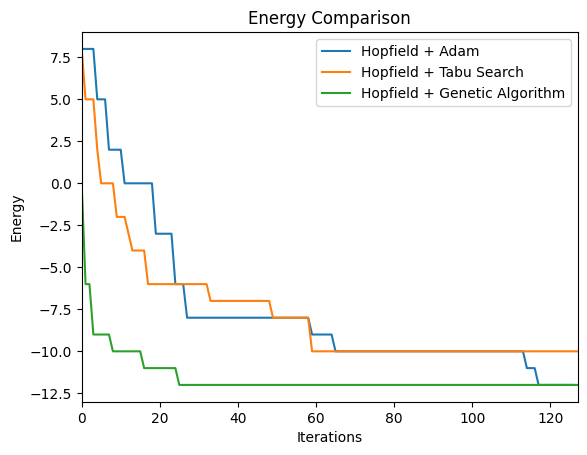

In [7]:
# Run Hopfield Neural Network optimization

# Run Adam
start = time.time()
adam_energy_history, adam_best_solution, adam_best_energy = HNN.AdamOptimizer(num_steps=10000)
end = time.time()
print(f"Adam took {end - start} seconds")

# Run Tabu Search
start = time.time()
tabu_energy_history, tabu_best_solution, tabu_best_energy = HNN.TabuSearch(num_steps=10000)
end = time.time()
print(f"Tabu took {end - start} seconds")

# Run Genetic Algorithm
start = time.time()
ga_energy_history, ga_best_solution, ga_best_energy = HNN.GeneticAlgorithm(num_steps=10000)
end = time.time()
print(f"GA took {end - start} seconds")

# Plot the energy histories to compare performance
import matplotlib.pyplot as plt

plt.plot(adam_energy_history, label='Hopfield + Adam')
plt.plot(tabu_energy_history, label='Hopfield + Tabu Search')
plt.plot(ga_energy_history, label='Hopfield + Genetic Algorithm')
plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.title('Energy Comparison')
plt.xlim(0,min(len(adam_energy_history),len(tabu_energy_history),len(ga_energy_history)))
plt.legend()
plt.show()


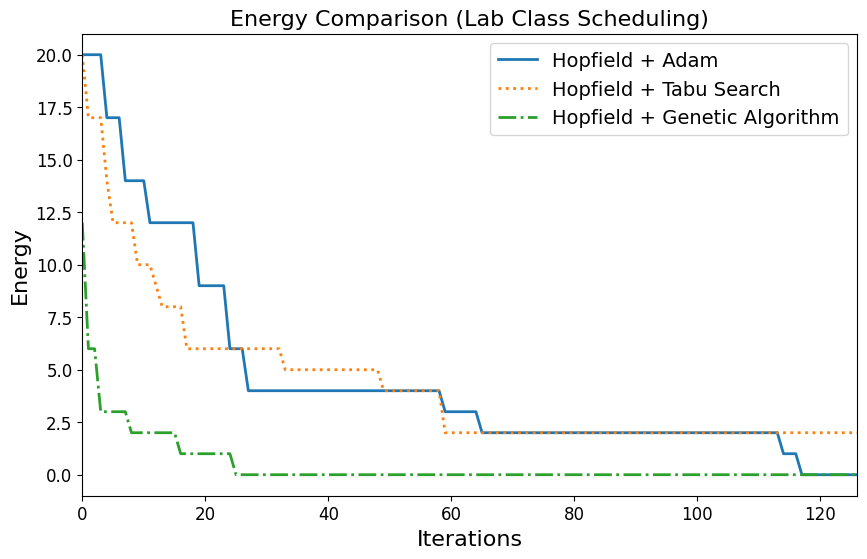

In [9]:
plt.figure(figsize=(10, 6))
Emin = ga_best_energy
t = min(len(adam_energy_history),len(tabu_energy_history),len(ga_energy_history))
plt.plot(adam_energy_history - Emin, label='Hopfield + Adam',linewidth=2)
plt.plot(tabu_energy_history - Emin, label='Hopfield + Tabu Search',linewidth=2,linestyle=':')
plt.plot(ga_energy_history - Emin, label='Hopfield + Genetic Algorithm',linewidth=2,linestyle='-.')
plt.xlabel('Iterations',fontsize=16)
plt.ylabel('Energy',fontsize=16)
plt.title('Energy Comparison (Lab Class Scheduling)',fontsize=16)
plt.legend(fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0,t-1)
# plt.yscale('log')

# plt.savefig('energy_comparison_HopfieldLT.png', dpi=600, bbox_inches='tight')
# plt.savefig('energy_comparison_HopfieldLT_log.png', dpi=600, bbox_inches='tight')

plt.show()